In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.datasets import mnist

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn 
from sklearn.metrics import roc_auc_score

import mlflow
import mlflow.tensorflow

c:\Users\user\miniconda3\envs\cc_env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  


In [2]:
print("TensorFlow: {}".format(tf.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))


TensorFlow: 2.4.1
Scikit-Learn: 0.22.1
Numpy: 1.19.5
MLFlow: 1.23.1
Matplotlib: 3.2.1


In [3]:
#load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Class:  5


(<matplotlib.image.AxesImage at 0x1a47c5bf630>, None)

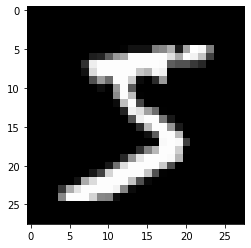

In [4]:
# plot one of the data samples
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])

* printed class label associated with sample number 5

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

* reshaping the data to include one channel -> `conforming with the specifications of the convolutional layers`. 
* Also `y sets` are being converted to one-hot encoded formats using the function `to_categorical()`

In [6]:
print(f'x train shape: {x_train.shape} \n y train shape: {y_train.shape}')

x train shape: (60000, 28, 28, 1) 
 y train shape: (60000, 10)


In [7]:
print(f"total length: {len(y_train[0])}")    #length matching total number of classes
print(f"one hot encoded label: {y_train[0]}")

total length: 10
one hot encoded label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


* whatever value the label was is now the index of the value 1 as seen on the result above
* So, if the label is 1, the value at the index of 1 in this vector will be one, and everything else is a 0. 
* as seen, the index of 1 above is `5`, corresponding to the first x_train example looked at earlier. 

In [8]:
#print shapes
print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape, y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape, y_test.shape))

Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


### MLFlow Run - Training and Evaluating 

In [9]:
# creating the model - using the Sequential method of model creation

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1), 
                 activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1), 
                 activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                11790     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 13,940
Trainable params: 13,940
Non-trainable params: 0
____________________________________________________

* creating the model and outputting model summary of the model's architecture

In [10]:
#compile model using Adam optimizer and categorical cross-entropy for the loss, setting the metric 
#  as the accuracy

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])


Now, have the MLFlow log the run. All the metrics to be logged to the same run. 
https://mlflow.org/docs/latest/models.html

In [11]:
'''mlflow to run a block of code in the context of the same run. 
to achieve that you block your code using: 
                        with mlflow.start_run():'''

mlflow.set_experiment("TF_Keras_MNIST")

with mlflow.start_run():  # chunks all your codes under the context of one MLFlow run.

    mlflow.tensorflow.autolog()  #log all params & metrics associated with particular tf/Keras model
    
    model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)
    preds = model.predict(x_test)
    preds = np.round(preds)

    eval_acc = model.evaluate(x_test, y_test)[1]
    auc_score = roc_auc_score(y_test, preds)

    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)

    mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
    mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
    
    # mlflow.tensorflow.log_model(artifact_path="tf-models",
    #                             registered_model_name='mnist_model')
    # Take the first three training examples as the model input example.
    # input_example = x_train[:3, :]
    # mlflow.tensorflow.log_model(model, "mnist_cnn", input_example=input_example) #literally loading the model

mlflow.end_run()

Epoch 1/10
235/235 [==============================] - 5s 19ms/step - loss: 3.0778 - accuracy: 0.4413
Epoch 2/10
235/235 [==============================] - 5s 19ms/step - loss: 0.3516 - accuracy: 0.8958 0s - loss: 0.356
Epoch 3/10
235/235 [==============================] - 5s 19ms/step - loss: 0.2040 - accuracy: 0.9395
Epoch 4/10
235/235 [==============================] - 4s 19ms/step - loss: 0.1508 - accuracy: 0.9570
Epoch 5/10
235/235 [==============================] - 4s 19ms/step - loss: 0.1134 - accuracy: 0.9660
Epoch 6/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0952 - accuracy: 0.9724 0s -
Epoch 7/10
235/235 [==============================] - 5s 23ms/step - loss: 0.0770 - accuracy: 0.9771 0s
Epoch 8/10
235/235 [==============================] - 6s 23ms/step - loss: 0.0675 - accuracy: 0.9799
Epoch 9/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0602 - accuracy: 0.9819
Epoch 10/10
235/235 [==============================] - 5s 19ms/ste

2023/07/20 09:37:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: module 'tensorflow.compat.v2.__internal__' has no attribute 'dispatch'


313/313 [==============================] - 1s 2ms/step - loss: 0.0784 - accuracy: 0.9752
eval_acc:  0.9751999974250793
auc_score:  0.985128306098002


### Loading an MLFlow Model

In [13]:
loaded_model = mlflow.keras.load_model("runs:/d36f1bfad0bb4939a912546f1f6cb6bb/model")

OSError: No such file or directory: 'D:\per\Codes\cloud_deployment\mlops\mlops-w-creditcard-data\mlruns\5\d36f1bfad0bb4939a912546f1f6cb6bb\artifacts\model'